In [25]:
%load_ext autoreload
%autoreload 2
import copy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from registration import *
from ndt import *
import numpy as np
import random

class RegistrationSimulation:
    def __init__(self):
        pass
        
    @staticmethod
    def getRandomCoefficients(x_start, x_end, a1_max=0.1, a2_max=0.1, bias_max=2):
        lx = 0
        while lx < 3:
            a1 = random.uniform(-a1_max, a1_max)
            a2 = random.uniform(-a2_max, a2_max)
            x1 = random.uniform(x_start, x_end)
            x2 = random.uniform(x_start, x_end)
            bias = random.uniform(-bias_max, bias_max)
            lx = max(x1,x2)-min(x1,x2)
        
        return (a1,a2,x1,x2,bias)
    
    @staticmethod
    def getRandomTransformation(tx_max=2., ty_max=2., theta_max=10.):
        
        theta, tx, ty = 0,0,0
        while abs(theta < 0.5) or (abs(tx) < 0.1 and abs(ty) < 0.1):
            tx = random.uniform(-tx_max, tx_max)
            ty = random.uniform(-ty_max, ty_max)
            theta = random.uniform(-theta_max, theta_max)
        
        print(f"theta = {theta}")
        return (tx,ty,theta)
    
    def generateMeasurements(self, random=True, lanes=False):
        if not random:
            if lanes:
                A = generatePolynom(x_start=-10, x_end=20, a0=15, a1=0.001, a2=0.)
                Am = generatePolynom(x_start=-6, x_end=14, a0=13, a1=0.001, a2=0.00)
                C = generatePolynom(x_start=-10, x_end=20, a0=11, a1=0.001, a2=0.)
                tx, ty, theta = 0,0,0
                self.parts=[0, Am.shape[0]]
                meas_offset = [20, -10]
                A = np.vstack((A, C))
                A[:, 0] += meas_offset[0]
                A[:, 1] += meas_offset[1]
                B = Am
                B[:, 0] += meas_offset[0]
                B[:, 1] += meas_offset[1]

                ego_pos = [0,0]
                BB = transformPolynom(B[:, 0:2], tx, ty, theta,center=ego_pos)
                BB = np.column_stack((BB, B[:, 2]))
                self.trans_init = np.diag([1,1,1,1])
                return (A, B, BB, tx, ty, theta)
            else:
                A = generatePolynom(x_start=-10, x_end=20, a0=13, a1=0.001, a2=0.03)
                #Am = generatePolynom(x_start=-8, x_end=16, a0=13, a1=0.001, a2=0.03)
                Am = generatePolynom(x_start=-6, x_end=14, a0=15, a1=0.001, a2=0.036)
                C = generatePolynom(x_start=-10, x_end=20, a0=2, a1=0.001, a2=0.03)
                #Cm = generatePolynom(x_start=-10, x_end=14, a0=2, a1=0.001, a2=0.03)
                Cm = generatePolynom(x_start=-5, x_end=14, a0=1, a1=0.001, a2=0.03)
                E = generatePolynom(x_start=0, x_end=30, a0=30, a1=0.001, a2=0.002,fx=False)
                #Em = generatePolynom(x_start=10, x_end=28, a0=30, a1=0.001, a2=0,fx=False)
                Em =  generatePolynom(x_start=20, x_end=28, a0=28.5, a1=0.00001, a2=0.002,fx=False)
                G = generatePolynom(x_start=0, x_end=14, a0=20, a1=0.001, a2=0,fx=False)
                tx, ty, theta = -1.5,-1.5,5
        else:
            (a1,a2,x1,x2,bias) = self.getRandomCoefficients(x_start=-10, x_end=20, a1_max=0.1, a2_max=0.05, bias_max=2)
            A = generatePolynom(x_start=-10, x_end=20, a0=19, a1=a1, a2=a2)   
            Am = generatePolynom(x_start=min(x1,x2), x_end=max(x1,x2), a0=19, a1=a1, a2=a2)
            Am = generatePolynom(x_start=min(x1,x2), x_end=max(x1,x2), a0=19+bias, a1=a1*(1+bias/10), a2=a2*(1+bias/10))
            (_,_,x1,x2,bias) = self.getRandomCoefficients(x_start=-10, x_end=20, a1_max=0.1, a2_max=0.05, bias_max=2)
            C = generatePolynom(x_start=-10, x_end=20, a0=-4, a1=a1, a2=a2)
            Cm = generatePolynom(x_start=min(x1,x2), x_end=max(x1,x2), a0=-4, a1=a1, a2=a2)
            Cm = generatePolynom(x_start=min(x1,x2), x_end=max(x1,x2), a0=-4+bias, a1=a1*(1+bias/10), a2=a2*(1+bias/10))
            (a1,a2,x1,x2,bias) = self.getRandomCoefficients(x_start=0, x_end=30, a1_max=0.01, a2_max=0.04, bias_max=2)
            E = generatePolynom(x_start=0, x_end=30, a0=30, a1=a1, a2=a2,fx=False)
            Em = generatePolynom(x_start=min(x1,x2), x_end=max(x1,x2), a0=30, a1=a1, a2=a2, fx=False)
            Em =generatePolynom(x_start=min(x1,x2), x_end=max(x1,x2), a0=30+bias, a1=a1*(1+bias/10), a2=a2*(1+bias/10),fx=False)
            (a1,a2,x1,x2,bias) = self.getRandomCoefficients(x_start=20, x_end=28, a1_max=0.01, a2_max=0.01, bias_max=2)
            G = generatePolynom(x_start=C[-1,1]-10, x_end=C[-1,1], a0=20, a1=0.001, a2=0,fx=False)
            (tx, ty, theta) = self.getRandomTransformation(tx_max=3., ty_max=3., theta_max=10.)
        
        self.parts=[0, Am.shape[0], Am.shape[0] + Cm.shape[0], Am.shape[0] + Cm.shape[0] + Em.shape[0]]
        meas_offset = [20, -10]
        A = np.vstack((A, C, E, G))
        A[:, 0] += meas_offset[0]
        A[:, 1] += meas_offset[1]
        B = np.vstack((Am, Cm, Em))
        B[:, 0] += meas_offset[0]
        B[:, 1] += meas_offset[1]
        
        ego_pos = [0,0]
        BB = transformPolynom(B[:, 0:2], tx, ty, theta,center=ego_pos)
        BB = np.column_stack((BB, B[:, 2]))
        self.trans_init = np.diag([1,1,1,1])
        
        return (A, B, BB, tx, ty, theta)
    
    def run(self, N=1, random=True, plotLF=False,lanes=False):
        if plotLF:
            self.initPlotLF()
        icp_rmse = np.zeros((N,3))
        ndt_rmse = np.zeros((N,3))
        lf_rmse = np.zeros((N,3))
        lf_imp_rmse = np.zeros((N,3))
        for i in range(0,N):
            (self.A, self.B, self.BB, self.tx, self.ty, self.theta) = self.generateMeasurements(random=random,lanes=lanes)
            #icp
            self.reg_icp = runICP(self.BB,self.A,self.trans_init,threshold=7)
            self.reg_ndt = ndt_match(self.BB[:,:2], self.A[:,:2],resolution=5,max_iter=120, tol=1e-9)
            self.TY = apply_transformation(self.BB[:,:2], self.reg_ndt)
            #LF Basic
            self.reg_lf, self.LFa, self.score = runLF(self.A,self.BB,self.trans_init,parts=self.parts,
                                       max_x_uncertainry=5, max_y_uncertainry=5, max_theta_uncertainry=abs(self.theta)+2,
                                                     method="_basic")
            #LF Improved
            self.reg_lf_imp, self.LFa_imp, self.score_imp = runLF(self.A,self.BB,self.trans_init,parts=self.parts,
                                       max_x_uncertainry=5, max_y_uncertainry=5, max_theta_uncertainry=abs(self.theta)+2,
                                                     method="_improved")
            print(f"ICP: Transformation is {self.reg_icp.transformation}")
            print(f"NDT: {self.reg_ndt}")
            print(f"LF Basic: Transformation is {self.reg_lf}")
            print(f"LF Improved: Transformation is {self.reg_lf_imp}")
            icp_rmse[i,0] = self.reg_icp.transformation[0,3]+self.tx
            icp_rmse[i,1] = self.reg_icp.transformation[1,3]+self.ty
            icp_rmse[i,2] = -np.rad2deg(np.arcsin(self.reg_icp.transformation[1,0]))+self.theta
            ndt_rmse[i,0] = self.reg_ndt[0]+self.tx
            ndt_rmse[i,1] = self.reg_ndt[1]+self.ty
            ndt_rmse[i,2] = -np.rad2deg(self.reg_ndt[2])+self.theta
            lf_rmse[i,0] = self.reg_lf[0]+self.tx
            lf_rmse[i,1] = self.reg_lf[1]+self.ty
            lf_rmse[i,2] = self.reg_lf[2]+self.theta
            lf_imp_rmse[i,0] = self.reg_lf_imp[0]+self.tx
            lf_imp_rmse[i,1] = self.reg_lf_imp[1]+self.ty
            lf_imp_rmse[i,2] = self.reg_lf_imp[2]+self.theta
            
            if plotLF:
                self.plotLF(i)
            
        icp_total_rmse = np.sqrt(np.sum(icp_rmse*icp_rmse,axis=0)) * 1/icp_rmse.shape[0]
        ndt_total_rmse = np.sqrt(np.sum(ndt_rmse*ndt_rmse,axis=0)) * 1/ndt_rmse.shape[0]
        lf_total_rmse = np.sqrt(np.sum(lf_rmse*lf_rmse,axis=0)) * 1/lf_rmse.shape[0]
        lf_imp_total_rmse = np.sqrt(np.sum(lf_imp_rmse*lf_imp_rmse,axis=0)) * 1/lf_imp_rmse.shape[0]
        
        print(f"icp_total_rmse = {icp_total_rmse} ndt_total_rmse = {ndt_total_rmse} lf_total_rmse = {lf_total_rmse} \
        lf_imp_total_rmse={lf_imp_total_rmse}")
        max_x_rob = 1.75
        max_y_rob = 1.75
        max_theta_rob = 10
        icp_success_rate = 1/N * np.sum(np.logical_and(np.logical_and(np.abs(icp_rmse[:,0]) < max_x_rob, np.abs(icp_rmse[:,1]) < max_y_rob), np.abs(icp_rmse[:,2]) < max_theta_rob))
        ndt_success_rate = 1/N * np.sum(np.logical_and(np.logical_and(np.abs(ndt_rmse[:,0]) < max_x_rob, np.abs(ndt_rmse[:,1]) < max_y_rob), np.abs(ndt_rmse[:,2]) < max_theta_rob))
        lf_success_rate = 1/N * np.sum(np.logical_and(np.logical_and(np.abs(lf_rmse[:,0]) < max_x_rob, np.abs(lf_rmse[:,1]) < max_y_rob), np.abs(lf_rmse[:,2]) < max_theta_rob))
        lf_imp_success_rate = 1/N * np.sum(np.logical_and(np.logical_and(np.abs(lf_imp_rmse[:,0]) < max_x_rob, np.abs(lf_imp_rmse[:,1]) < max_y_rob), np.abs(lf_imp_rmse[:,2]) < max_theta_rob))
        
        print(f"icp_success_rate = {icp_success_rate} ndt_success_rate = {ndt_success_rate} lf_success_rate = {lf_success_rate} \
        lf_imp_success_rate = {lf_imp_success_rate}")
        if lanes:
            self.plotLanes()
        
    def plot(self):
        fig = plt.figure(figsize=(25,25))
        gs = gridspec.GridSpec(3, 2)
        ax = [None, None, None, None, None, None]
        ax[0] = plt.subplot(gs[0, 0])  # First row, first column
        ax[1] = plt.subplot(gs[0, 1])  # First row, second column
        ax[2] = plt.subplot(gs[1, 0])  # Second row, first column
        ax[3] = plt.subplot(gs[1, 1])  # Second row, second column
        ax[4] = plt.subplot(gs[2, 0])  # Third row, first column
        ax[5] = plt.subplot(gs[2, 1])  # Third row, second column
        
        #Graph: true & Initial pose
        ax[0].scatter(self.A[:,0], self.A[:,1], label='Target map')
        ax[0].scatter(self.B[:, 0],self.B[:, 1], label='Observation')
        plotEGO(ax[0], trns=[0,0], rot=0, color='green',label='True pose')
        ax[0].set_title('True Pose Perspective', fontsize=28)

        ax[1].scatter(self.A[:,0], self.A[:,1], label='Target map')
        ax[1].scatter(self.BB[:, 0],self.BB[:, 1], label='Observation')
        plotEGO(ax[1], trns=[0,0], rot=0, color='green',label='True pose')
        plotEGO(ax[1], trns=[self.tx,self.ty], rot=-self.theta, color='red',label='Estimated pose')
        ax[1].set_title('Initial Pose Perspective', fontsize=28)

        #Graph: ICP & NDT
        ax[2].scatter(self.A[:,0], self.A[:,1], label='Target map')
        b = np.ones((self.BB.shape[0],1))
        Be = np.hstack((self.BB,b))
        Bt = np.dot(self.reg_icp.transformation,Be.T)
        Bt = Bt.T
        ax[2].scatter(Bt[:, 0],Bt[:, 1], label='Observation')
        plotEGO(ax[2], trns=[0,0], rot=0, color='green',label='True pose')
        print(f"ICP = {[self.reg_icp.transformation[0,3]+self.tx,self.reg_icp.transformation[1,3]+self.ty]}")
        plotEGO(ax[2], trns=[self.reg_icp.transformation[0,3]+self.tx,self.reg_icp.transformation[1,3]+self.ty], 
                rot=(np.rad2deg(np.arcsin(self.reg_icp.transformation[1,0]))-self.theta),color='red',label='Estimated pose')
        ax[2].set_title('ICP Estimate Pose Perspective', fontsize=28)

        ax[3].scatter(self.A[:,0], self.A[:,1], label='Target map')
        ax[3].scatter(self.TY[:, 0],self.TY[:, 1], label='Observation') 
        plotEGO(ax[3], trns=[0,0], rot=0, color='green',label='True pose')
        print(f"NDT = {self.reg_ndt}")
        plotEGO(ax[3], trns=[self.reg_ndt[0]+self.tx, self.reg_ndt[1]+self.ty], 
                rot=np.rad2deg(self.reg_ndt[2])-self.theta,color='red',label='Estimated pose')
        ax[3].set_title('NDT Estimate Pose Perspective', fontsize=28)

        #Graph: LF Basic
        ax[4].scatter(self.A[:,0], self.A[:,1], label='Target map')
        Bt = transformPolynom(self.BB[:,0:2], self.reg_lf[0], self.reg_lf[1], self.reg_lf[2])
        ax[4].scatter(Bt[:, 0],Bt[:, 1], label='Observation') 
        plotEGO(ax[4], trns=[0,0], rot=0, color='green',label='True pose')
        plotEGO(ax[4], trns=[self.reg_lf[0]+self.tx, self.reg_lf[1]+self.ty], 
                rot=(-self.reg_lf[2]-self.theta),color='red',label='Estimated pose')
        ax[4].set_title('LF Basic Estimate Pose Perspective', fontsize=28)
        
        #Graph: LF Improved
        ax[5].scatter(self.A[:,0], self.A[:,1], label='Target map')
        Bt = transformPolynom(self.BB[:,0:2], self.reg_lf_imp[0], self.reg_lf_imp[1], self.reg_lf_imp[2])
        ax[5].scatter(Bt[:, 0],Bt[:, 1], label='Observation') 
        plotEGO(ax[5], trns=[0,0], rot=0, color='green',label='True pose')
        plotEGO(ax[5], trns=[self.reg_lf_imp[0]+self.tx, self.reg_lf_imp[1]+self.ty], 
                rot=(-self.reg_lf_imp[2]-self.theta),color='red',label='Estimated pose')
        ax[5].set_title('LF Improved Estimate Pose Perspective', fontsize=28)

        for i in range(0,6):
            ax[i].set_xlabel('x [m]', fontsize=32, labelpad=20.0)
            ax[i].set_ylabel('y [m]', fontsize=32, labelpad=20.0)
            ax[i].tick_params(axis='both', which='both', labelsize=22)
            ax[i].legend(fontsize=20)
            ax[i].axis('equal')

        plt.subplots_adjust(hspace=0.5, top=0.93)  # Adjust the vertical spacing
        fig.suptitle(f"Pose Estimation Results Comparison For Initial Pose ({self.tx:.2f}[m], {self.ty:.2f}[m], {-self.theta:.2f}[deg])", fontsize=36)
        fig.text(0.3, 0.69, '(a)', fontsize=28, ha='center')
        fig.text(0.16, 0.39, '(b)', fontsize=28, ha='center')
        fig.text(0.6, 0.39, '(c)', fontsize=28, ha='center')
        fig.text(0.16, 0.09, '(d)', fontsize=28, ha='center')
        fig.text(0.6, 0.09, '(e)', fontsize=28, ha='center')
        #fig.text(0.6, 0.09, '(f)', fontsize=28, ha='center')
        
    def initPlotLF(self):
        self.fig, self.ax = plt.subplots(4,2,figsize=(20,15),sharex=False,sharey=False)
        gs = gridspec.GridSpec(2, 2)
        plt.subplots_adjust(hspace=0.4, top=0.94)  # Adjust the vertical spacing
        self.fig.suptitle(f"LF Pose Estimation Results In Multiple Trials", fontsize=36)
        for i in range(0,4):
            for j in range(0,2):
                self.ax[i,j].set_xlabel('x [m]', fontsize=28, labelpad=20.0)
                self.ax[i,j].set_ylabel('y [m]', fontsize=28, labelpad=20.0)
                self.ax[i,j].tick_params(axis='both', which='both', labelsize=22)
                self.ax[i,j].legend(fontsize=20)
                self.ax[i,j].axis('equal')
                
    def plotLanes(self):
        fig, ax = plt.subplots(1,2,figsize=(20,8), sharex=False, sharey=False)

        # Set the offset between the road borders
        road_offset = 4  # 4 meters
        walkway_offset = 8  # 3 meters
        # Draw the road borders (two straight dashed lines)
        road_border_x = [0, 40]  # Change the x-coordinates based on your desired road length
        road_border_y = [road_offset, road_offset]
        ax[0].plot(road_border_x, road_border_y, 'k')
        # Draw the walkway border (straight blue line parallel to the road)
        walkway_x = [0, 40]  # Change the x-coordinates based on your desired road length
        walkway_y = [walkway_offset, walkway_offset]
        ax[0].plot(walkway_x, walkway_y, 'k')
        #Fill in road & walkway
        ax[0].fill_between(road_border_x, road_border_y, -road_offset, color='blue', alpha=0.5, label='Road')
        ax[0].fill_between(walkway_x, walkway_y, -walkway_offset, color='gray', alpha=0.5, label='Walkway')
        #Draw measurement
        meas_x = [10, 30]  # Change the x-coordinates based on your desired road length
        meas_y = [6, 6]
        ax[0].plot(meas_x, meas_y, 'orange', label='Measurement')
        #Pas
        pas_x = [0, 40]  # Change the x-coordinates based on your desired road length
        pas_y = [0, 0]
        ax[0].plot(pas_x, pas_y, '--w',lw=4)
        #2nd road
        road_border_x = [0, 40]  # Change the x-coordinates based on your desired road length
        road_border_y = [-4, -4]
        ax[0].fill_between(road_border_x, road_border_y, -road_offset, color='blue', alpha=0.5)
        #EGO
        plotEGO(ax[0], trns=[-1.,-0.75], rot=0, label='Ego Pose Estimate')
        ax[0].axis('equal')
        #Arrows
        # Add arrows
        ax[0].arrow(20, 6, 0, 1.5, head_width=0.5, head_length=0.5, fc='black', ec='black')
        ax[0].arrow(20, 6, 0, -1.5, head_width=0.5, head_length=0.5, fc='black', ec='black')
        #Uncertainty
        uncertainty_x = [-3, 4]  # Change the x-coordinates based on your desired road length
        uncertainty_y = [-3, -3]
        ax[0].fill_between(uncertainty_x, uncertainty_y, 3, color='red', alpha=0.6, label='Pose Uncertainty')

        # Set axis labels and legend
        ax[0].set_xlabel('X')
        ax[0].set_ylabel('Y')
        ax[0].legend()
        ax[0].set_xlabel('x [m]', fontsize=28, labelpad=20.0)
        ax[0].set_ylabel('y [m]', fontsize=28, labelpad=20.0)
        ax[0].tick_params(axis='both', which='both', labelsize=22)
        ax[0].legend(fontsize=18)
        ax[0].set_ylim([0,10])
        
        sc = ax[1].imshow(self.score[:,10:-10,4].T, cmap='jet')
        ax[1].grid(False)
        ax[1].set_xticks([0,20,40,60,80,100])
        ax[1].set_xticklabels([-3.75, -2.25, -0.75, 0.75, 2.25, 3.75])
        ax[1].set_yticks([0,20,40,60,80])
        ax[1].set_yticklabels([-3, -1.5, 0, 1.5, 3])  # Specify the tick positions and labels for the y-axis
        ax[1].set_xlabel('x [m]', fontsize=28, labelpad=20.0)
        ax[1].set_ylabel('y [m]', fontsize=28, labelpad=20.0)
        ax[1].tick_params(axis='both', which='both', labelsize=22)
        
        # Customize the colorbar label
        cbar = plt.colorbar(sc)
        cbar.set_label('Score',fontsize=30)
        cbar.ax.tick_params(labelsize=22)
        fig.suptitle(r"Multimodal Score Function s($\vec{x}$)", fontsize=28)

    def plotLF(self, i):
        self.ax[i,0].scatter(self.A[:,0], self.A[:,1], label='Target map')
        self.ax[i,0].scatter(self.BB[:, 0],self.BB[:, 1], label='Observation')
        plotEGO(self.ax[i,0], trns=[0,0], rot=0, color='green',label='True pose')
        plotEGO(self.ax[i,0], trns=[self.tx,self.ty], rot=-self.theta, color='red',label='Estimated pose')
        self.ax[i,0].set_title(f'Initial Pose Perspective in Trial={i}', fontsize=28)
        self.ax[i,0].set_xlim([-15,80])
        self.ax[i,0].set_ylim([-40,30])
        
        #Graph: LF
        self.ax[i,1].scatter(self.A[:,0], self.A[:,1], label='Target map')
        Bt = transformPolynom(self.BB[:,0:2], self.reg_lf[0], self.reg_lf[1], self.reg_lf[2])
        self.ax[i,1].scatter(Bt[:, 0],Bt[:, 1], label='Observation') 
        plotEGO(self.ax[i,1], trns=[0,0], rot=0, color='green',label='True pose')
        plotEGO(self.ax[i,1], trns=[self.reg_lf[0]+self.tx, self.reg_lf[1]+self.ty], 
                rot=(-self.reg_lf[2]-self.theta),color='red',label='Estimated pose')
        self.ax[i,1].set_title(f'LF Estimate Pose Perspective in Trial={i}', fontsize=28)
        self.ax[i,1].set_xlim([-15,80])
        self.ax[i,1].set_ylim([-40,30])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
sim = RegistrationSimulation()
sim.run(N=1,random=True, plotLF=False,lanes=False)

theta = 8.263932623620903
best is  (19, 12, 0)
ith0 = 6 ipart = 3 low_sigma_score = 25.089018108889437 high_sigma_score = 8.804027814810999
best is  (16, 15, 0)
ICP: Transformation is [[ 0.98955066 -0.14418559  0.          2.06803106]
 [ 0.14418559  0.98955066  0.          3.61895083]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
NDT: [0. 0. 0.]
LF Basic: Transformation is (-3.1000000000000068, -3.8000000000000043, -10.263932623620903)
LF Improved: Transformation is (-3.4000000000000057, -3.5000000000000053, -10.263932623620903)
icp_total_rmse = [0.8969941  0.99966859 0.02618898] ndt_total_rmse = [2.96502516 2.61928224 8.26393262] lf_total_rmse = [6.06502516 6.41928224 2.        ]         lf_imp_total_rmse=[6.36502516 6.11928224 2.        ]
icp_success_rate = 1.0 ndt_success_rate = 0.0 lf_success_rate = 0.0         lf_imp_success_rate = 0.0


ICP = [-0.8969940955753875, 0.9996685928567004]
NDT = [0. 0. 0.]


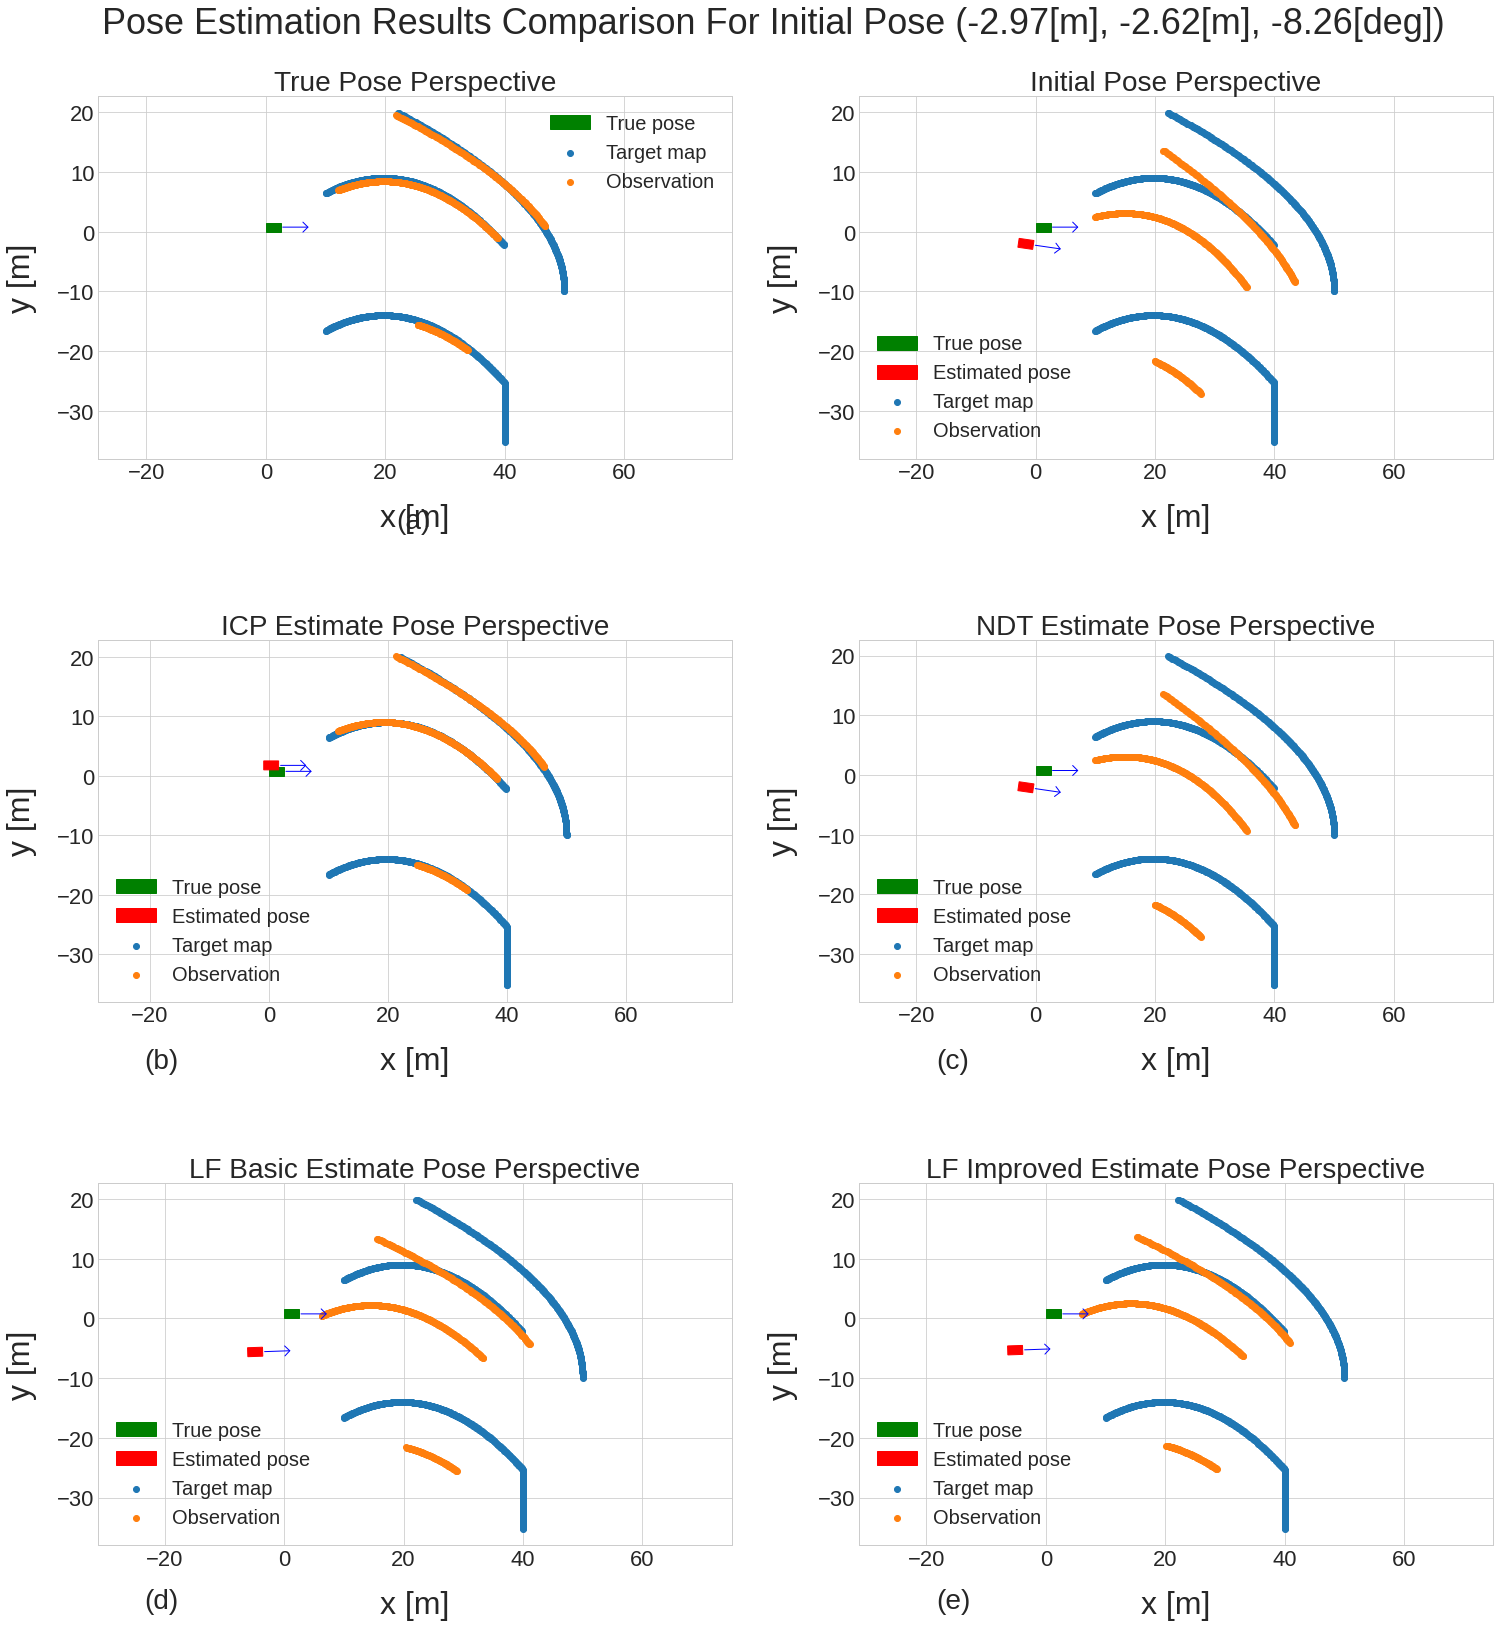

In [52]:
sim.plot()

In [195]:
%load_ext autoreload
%autoreload 2
import copy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from registration import *
from ndt import *
import numpy as np
import random
from tqdm.notebook import tqdm

class RegistrationSimulation:
    def __init__(self):
        self.LF_basic = LF()
        self.LF_improved = LF()
        
    @staticmethod
    def getRandomCoefficients(x_start, x_end, a1_max=0.1, a2_max=0.1, bias_max=2):
        lx = 0
        while lx < 3:
            a1 = random.uniform(-a1_max, a1_max)
            a2 = random.uniform(-a2_max, a2_max)
            x1 = random.uniform(x_start, x_end)
            x2 = random.uniform(x_start, x_end)
            bias = random.uniform(-bias_max, bias_max)
            lx = max(x1,x2)-min(x1,x2)
        
        return (a1,a2,x1,x2,bias)
    
    @staticmethod
    def getRandomTransformation(tx_max=5., ty_max=5., theta_max=5.):
        
        theta, tx, ty = 0,0,0
        while abs(theta < 0.5) or (abs(tx) < 0.1 and abs(ty) < 0.1):
            tx = random.uniform(-tx_max, tx_max)
            ty = random.uniform(-ty_max, ty_max)
            theta = random.uniform(-theta_max, theta_max)
        
        print(f"Random transformation is [{tx},{ty},{theta}]")
        return (tx,ty,theta)
    
    def generateMeasurements(self, shape, random=True):
        if random:
            offset1 = np.random.normal(0, 2)
            offset2 = np.random.normal(0, 2)
            print(f"offsets are = ({offset1},{offset2})")
        else:
            offset1 = -2
            offset2 = -1
            
        if shape == "Line":
            A = generatePolynom(x_start=-10, x_end=20, a0=15, a1=0.001, a2=0.)
            Am = generatePolynom(x_start=-6, x_end=14, a0=15+offset1, a1=0.001, a2=0.00)
            C = generatePolynom(x_start=-10, x_end=20, a0=5, a1=0.001, a2=0.)
            Cm = generatePolynom(x_start=-6, x_end=14, a0=5+offset2, a1=0.001, a2=0.00)

        self.parts=[0, Am.shape[0], Am.shape[0] + Cm.shape[0]]
        meas_offset = [20, -10]
        A = np.vstack((A, C))
        A[:, 0] += meas_offset[0]
        A[:, 1] += meas_offset[1]
        B = np.vstack((Am, Cm))
        B[:, 0] += meas_offset[0]
        B[:, 1] += meas_offset[1]
            
        return A,B
    
    def applyTransformation(self, B,
                            tx, ty, theta):
        ego_pos = [0,0]
        BB = transformPolynom(B[:, 0:2], tx, ty, theta,center=ego_pos)
        BB = np.column_stack((BB, B[:, 2]))
        self.trans_init = np.diag([1,1,1,1])
        return BB
    
    def run(self, N=1, plotLF=False, shape="Line"):
        if plotLF:
            self.initPlotLF()
        
        X0 = Y0 = np.arange(-3, 3+1e-6, 3)
        TH0 = np.arange(-5, 5+1e-6, 2)
        M = N * len(X0) * len(Y0) * len(TH0)
        initial_res = np.zeros((M,3))
        icp_res = np.zeros((M,3))
        ndt_res = np.zeros((M,3))
        lf_res = np.zeros((M,3))
        lf_imp_res = np.zeros((M,3))
        i = 0
        for j in tqdm(range(0,N)):
            self.A, self.B  = self.generateMeasurements(shape=shape)
            for ix0, x0 in enumerate(np.nditer(X0)):
                for iy0, y0 in enumerate(np.nditer(Y0)):
                    for ith0, th0 in enumerate(np.nditer(TH0)):
                        #print(f"Exp {i} transformation = ({x0}, {y0}, {th0})")
                        self.tx = float(x0)
                        self.ty = float(y0)
                        self.theta = float(th0)
                        self.BB = self.applyTransformation(self.B, self.tx, self.ty, self.theta)
                        # ICP
                        self.reg_icp = runICP(self.BB,self.A,self.trans_init,threshold=7)
                        # NDT 
                        self.reg_ndt = ndt_match(self.BB[:,:2], self.A[:,:2],resolution=3,max_iter=120, tol=1e-9)
                        self.TY = apply_transformation(self.BB[:,:2], self.reg_ndt)
                        #LF Basic
                        self.LF_basic.buildMaps(self.A)
                        self.reg_lf, self.LFa, self.score = self.LF_basic.run(self.A,self.BB,parts=self.parts,
                                                   max_x_uncertainry=5, max_y_uncertainry=5, max_theta_uncertainry=6, \
                                                                 method="_basic")
                        #LF Improved
                        self.LF_improved.buildMaps(self.A)
                        self.reg_lf_imp, self.LFa_imp, self.score_imp = self.LF_improved.run(self.A,self.BB,parts=self.parts,
                                                   max_x_uncertainry=5, max_y_uncertainry=5, max_theta_uncertainry=6, \
                                                                 method="_improved")

                        initial_res[i,0] = self.tx
                        initial_res[i,1] = self.ty
                        initial_res[i,2] = self.theta
                        icp_res[i,0] = self.reg_icp.transformation[0,3]
                        icp_res[i,1] = self.reg_icp.transformation[1,3]
                        icp_res[i,2] = -np.rad2deg(np.arcsin(self.reg_icp.transformation[1,0]))
                        icp_res[i,:] += initial_res[i,:]
                        ndt_res[i,0] = self.reg_ndt[0]
                        ndt_res[i,1] = self.reg_ndt[1]
                        ndt_res[i,2] = -np.rad2deg(self.reg_ndt[2])
                        ndt_res[i,:] += initial_res[i,:]
                        lf_res[i,0] = self.reg_lf[0]
                        lf_res[i,1] = self.reg_lf[1]
                        lf_res[i,2] = self.reg_lf[2]
                        lf_res[i,:] += initial_res[i,:]
                        lf_imp_res[i,0] = self.reg_lf_imp[0]
                        lf_imp_res[i,1] = self.reg_lf_imp[1]
                        lf_imp_res[i,2] = self.reg_lf_imp[2]
                        lf_imp_res[i,:] += initial_res[i,:]
                        i += 1
            
            if plotLF:
                self.plotLF(j)
                
        initial_mean = np.mean(initial_res, axis=0)
        initial_std = np.std(initial_res, axis=0)
        icp_mean = np.mean(icp_res, axis=0)
        icp_std = np.std(icp_res, axis=0)
        ndt_mean = np.mean(ndt_res, axis=0)
        ndt_std = np.std(ndt_res, axis=0)
        lf_mean = np.mean(lf_res, axis=0)
        lf_std = np.std(lf_res, axis=0)
        lf_imp_mean = np.mean(lf_imp_res, axis=0)
        lf_imp_std = np.std(lf_imp_res, axis=0)
            
        icp_total_rmse = np.sqrt(np.sum(icp_res*icp_res,axis=0)) * 1/icp_res.shape[0]
        ndt_total_rmse = np.sqrt(np.sum(ndt_res*ndt_res,axis=0)) * 1/ndt_res.shape[0]
        lf_total_rmse = np.sqrt(np.sum(lf_res*lf_res,axis=0)) * 1/lf_res.shape[0]
        lf_imp_total_rmse = np.sqrt(np.sum(lf_imp_res*lf_imp_res,axis=0)) * 1/lf_imp_res.shape[0]
        
        print(f"initial = ({initial_mean},{initial_std})")
        print(f"icp = ({icp_mean},{icp_std})")
        print(f"ndt = ({ndt_mean},{ndt_std})")
        print(f"LF basic = ({lf_mean},{lf_std})")
        print(f"LF improved = ({lf_imp_mean},{lf_imp_std})")
        #print(f"icp_total_rmse = {icp_total_rmse} ndt_total_rmse = {ndt_total_rmse} lf_total_rmse = {lf_total_rmse} \
        #lf_imp_total_rmse={lf_imp_total_rmse}")
        
        self.initial_res = initial_res
        self.icp_res = icp_res
        self.ndt_res = ndt_res
        self.lf_res = lf_res
        self.lf_imp_res = lf_imp_res
        
    def plot(self, it):
        self.tx, self.ty, self.theta = self.initial_res[it,0], self.initial_res[it,1], self.initial_res[it,2]
        BB = self.applyTransformation(self.B, self.tx, self.ty, self.theta)
        fig = plt.figure(figsize=(25,25))
        gs = gridspec.GridSpec(3, 2)
        ax = [None, None, None, None, None, None]
        ax[0] = plt.subplot(gs[0, 0])  # First row, first column
        ax[1] = plt.subplot(gs[0, 1])  # First row, second column
        ax[2] = plt.subplot(gs[1, 0])  # Second row, first column
        ax[3] = plt.subplot(gs[1, 1])  # Second row, second column
        ax[4] = plt.subplot(gs[2, 0])  # Third row, first column
        ax[5] = plt.subplot(gs[2, 1])  # Third row, second column
        
        #Graph: true & Initial pose
        ax[0].scatter(self.A[:,0], self.A[:,1], label='Target map')
        ax[0].scatter(self.B[:, 0],self.B[:, 1], label='Observation')
        plotEGO(ax[0], trns=[0,0], rot=0, color='green',label='True pose')
        ax[0].set_title('True Pose Perspective', fontsize=28)
        
        ax[1].scatter(self.A[:,0], self.A[:,1], label='Target map')
        ax[1].scatter(BB[:, 0],BB[:, 1], label='Observation')
        plotEGO(ax[1], trns=[0,0], rot=0, color='green',label='True pose')
        plotEGO(ax[1], trns=[self.tx,self.ty], rot=-self.theta, color='red',label='Estimated pose')
        ax[1].set_title('Initial Pose Perspective', fontsize=28)

        #Graph: ICP & NDT
        ax[2].scatter(self.A[:,0], self.A[:,1], label='Target map')
        Bt = transformPolynom(self.B[:,0:2], self.icp_res[it,0], self.icp_res[it,1], self.icp_res[it,2])
        ax[2].scatter(Bt[:, 0],Bt[:, 1], label='Observation')
        plotEGO(ax[2], trns=[0,0], rot=0, color='green',label='True pose')
        plotEGO(ax[2], trns=[self.icp_res[it,0],self.icp_res[it,1]], 
                rot=-self.icp_res[it,1],color='red',label='Estimated pose')
        ax[2].set_title('ICP Estimate Pose Perspective', fontsize=28)

        ax[3].scatter(self.A[:,0], self.A[:,1], label='Target map')
        Bt = transformPolynom(self.B[:,0:2], self.ndt_res[it,0], self.ndt_res[it,1], self.ndt_res[it,2])
        ax[3].scatter(Bt[:, 0],Bt[:, 1], label='Observation') 
        plotEGO(ax[3], trns=[0,0], rot=0, color='green',label='True pose')
        plotEGO(ax[3], trns=[self.ndt_res[it,0], self.ndt_res[it,1]], 
                rot=-self.ndt_res[it,2],color='red',label='Estimated pose')
        ax[3].set_title('NDT Estimate Pose Perspective', fontsize=28)

        #Graph: LF Basic
        ax[4].scatter(self.A[:,0], self.A[:,1], label='Target map')
        Bt = transformPolynom(self.B[:,0:2], self.lf_res[it,0], self.lf_res[it,1], self.lf_res[it,2])
        ax[4].scatter(Bt[:, 0],Bt[:, 1], label='Observation') 
        plotEGO(ax[4], trns=[0,0], rot=0, color='green',label='True pose')
        plotEGO(ax[4], trns=[self.lf_res[it,0], self.lf_res[it,1]], 
                rot=-self.lf_res[it,2],color='red',label='Estimated pose')
        ax[4].set_title('LF Basic Estimate Pose Perspective', fontsize=28)
        
        #Graph: LF Improved
        ax[5].scatter(self.A[:,0], self.A[:,1], label='Target map')
        print(f"self.lf_imp_res[it] = {self.lf_imp_res[it, :]}")
        Bt = transformPolynom(self.B[:,0:2], self.lf_imp_res[it,0], self.lf_imp_res[it,1], self.lf_imp_res[it,2])
        ax[5].scatter(Bt[:, 0],Bt[:, 1], label='Observation') 
        plotEGO(ax[5], trns=[0,0], rot=0, color='green',label='True pose')
        plotEGO(ax[5], trns=[self.lf_imp_res[it,0], self.lf_imp_res[it,1]], 
                rot=-self.lf_imp_res[it,2],color='red',label='Estimated pose')
        ax[5].set_title('LF Improved Estimate Pose Perspective', fontsize=28)

        for i in range(0,6):
            ax[i].set_xlabel('x [m]', fontsize=32, labelpad=20.0)
            ax[i].set_ylabel('y [m]', fontsize=32, labelpad=20.0)
            ax[i].tick_params(axis='both', which='both', labelsize=22)
            ax[i].legend(fontsize=20)
            ax[i].axis('equal')

        plt.subplots_adjust(hspace=0.5, top=0.93)  # Adjust the vertical spacing
        fig.suptitle(f"Pose Estimation Results Comparison For Initial Pose ({self.tx:.2f}[m], {self.ty:.2f}[m], {-self.theta:.2f}[deg])", fontsize=36)
        fig.text(0.3, 0.69, '(a)', fontsize=28, ha='center')
        fig.text(0.16, 0.39, '(b)', fontsize=28, ha='center')
        fig.text(0.6, 0.39, '(c)', fontsize=28, ha='center')
        fig.text(0.16, 0.09, '(d)', fontsize=28, ha='center')
        fig.text(0.6, 0.09, '(e)', fontsize=28, ha='center')
        #fig.text(0.6, 0.09, '(f)', fontsize=28, ha='center')
        
    def initPlotLF(self):
        self.fig, self.ax = plt.subplots(4,2,figsize=(20,15),sharex=False,sharey=False)
        gs = gridspec.GridSpec(2, 2)
        plt.subplots_adjust(hspace=0.4, top=0.94)  # Adjust the vertical spacing
        self.fig.suptitle(f"LF Pose Estimation Results In Multiple Trials", fontsize=36)
        for i in range(0,4):
            for j in range(0,2):
                self.ax[i,j].set_xlabel('x [m]', fontsize=28, labelpad=20.0)
                self.ax[i,j].set_ylabel('y [m]', fontsize=28, labelpad=20.0)
                self.ax[i,j].tick_params(axis='both', which='both', labelsize=22)
                self.ax[i,j].legend(fontsize=20)
                self.ax[i,j].axis('equal')

    def plotLF(self, i):
        self.ax[i,0].scatter(self.A[:,0], self.A[:,1], label='Target map')
        self.ax[i,0].scatter(self.BB[:, 0],self.BB[:, 1], label='Observation')
        plotEGO(self.ax[i,0], trns=[0,0], rot=0, color='green',label='True pose')
        plotEGO(self.ax[i,0], trns=[self.tx,self.ty], rot=-self.theta, color='red',label='Estimated pose')
        self.ax[i,0].set_title(f'Initial Pose Perspective in Trial={i}', fontsize=28)
        self.ax[i,0].set_xlim([-15,80])
        self.ax[i,0].set_ylim([-40,30])
        
        #Graph: LF
        self.ax[i,1].scatter(self.A[:,0], self.A[:,1], label='Target map')
        Bt = transformPolynom(self.BB[:,0:2], self.reg_lf[0], self.reg_lf[1], self.reg_lf[2])
        self.ax[i,1].scatter(Bt[:, 0],Bt[:, 1], label='Observation') 
        plotEGO(self.ax[i,1], trns=[0,0], rot=0, color='green',label='True pose')
        plotEGO(self.ax[i,1], trns=[self.reg_lf[0]+self.tx, self.reg_lf[1]+self.ty], 
                rot=(-self.reg_lf[2]-self.theta),color='red',label='Estimated pose')
        self.ax[i,1].set_title(f'LF Estimate Pose Perspective in Trial={i}', fontsize=28)
        self.ax[i,1].set_xlim([-15,80])
        self.ax[i,1].set_ylim([-40,30])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
sim = RegistrationSimulation()
sim.run(N=1)

offsets are = (3.455979300782326,2.1958414310364858)


/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


In [ ]:
sim.plot(-1)

In [80]:
t_res = 0.2
np.arange(-t_res,t_res+1e-6,t_res)

array([-0.2,  0. ,  0.2])